# Activity - Physical Event - Physical Health

## Dataset y libraries

### Library installation

### Library imports

In [61]:
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import folium
from shapely.geometry import LineString
import geopandas as gpd
from folium.plugins import PolyLineTextPath
import branca.colormap as cm
from datetime import datetime
from datetime import timedelta
from gettext import install

### Data import

In [62]:
# Importamos el Activity_Event_
with open('data_sources/simulation/physical_health/events/activity_event.json') as file:
    data = json.load(file)

## Summary of workout (Activity event)

### Activity route map

#### Code

In [63]:
# Extract position and velocity data
activity = data['physical_health']['events']['activity_event'][0]
position_data = activity['position']['position_granular_data_array']
speed_data = activity['movement']['speed_granular_data_array']

# Converting data into DataFrames
position_df = pd.DataFrame(position_data)
speed_df = pd.DataFrame(speed_data)

# Merge DataFrames by 'datetime_string' field
combined_df = pd.merge(position_df, speed_df, on='datetime_string')

# Convert speed from meters per second to kilometers per hour
combined_df['speed_kmh'] = combined_df['speed_meters_per_second_float'] * 3.6

# Create map centered on first position, with adjusted size
map_center = [combined_df.iloc[0]['lat_deg_float'], combined_df.iloc[0]['lng_deg_float']]
mymap = folium.Map(location=map_center, zoom_start=17)

# Create a colormap
min_speed = combined_df['speed_kmh'].min()
max_speed = combined_df['speed_kmh'].max()
colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow', 'orange', 'red'], vmin=min_speed, vmax=max_speed)

# Add route to map with gradient colors
points = combined_df[['lat_deg_float', 'lng_deg_float']].values.tolist()
speeds = combined_df['speed_kmh'].tolist()

for i in range(len(points) - 1):
    folium.PolyLine(
        locations=[points[i], points[i + 1]],
        color=colormap(speeds[i]),
        weight=5
    ).add_to(mymap)


#### GPS map

In [64]:
# Add colormap legend
colormap.add_to(mymap)

# Show map
mymap

### Activity info

In [65]:
# We will use the variable "activity_type_name_string"
# We will use the variable "activity_start_datetime_string"

def translate_date(date_str):
    months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    dt = datetime.fromisoformat(date_str.replace("Z", "+00:00"))
    return f"{months[dt.month - 1]} {dt.day}, {dt.year} at {dt.hour:02d}:{dt.minute:02d}"

workout_type = data['physical_health']['events']['activity_event'][0]['activity']['activity_type_name_string']
original_date = data['physical_health']['events']['activity_event'][0]['activity']['activity_start_datetime_string']
translated_date = translate_date(original_date)
    
print(f"Workout type: {workout_type}")
print(f"Event date: {translated_date}\n")

#Remember: You must set the date according to your time zone.

Workout type: Running
Event date: June 13, 2024 at 19:33



### Workout Distance

In [66]:
# We will use the variable of "traveled_distance_meters_float"

traveled_distance = data['physical_health']['events']['activity_event'][0]['distance']['traveled_distance_meters_float']

if traveled_distance is None:
    traveled_distance_result = "The values ​​for the distance traveled are not available"

else:
    traveled_distance_km = round(traveled_distance / 1000, 3)
    traveled_distance_result = f" Traveled distance: {traveled_distance_km} km."

print(traveled_distance_result)


 Traveled distance: 4.775 km.


### Activity Time

In [67]:
activity_time = data['physical_health']['events']['activity_event'][0]['activity']['active_seconds_int']

if activity_time is None:
    activity_time_result = "The values ​​for the distance traveled are not available"
    
else:
    activity_time_minutes = activity_time // 60
    activity_time_seconds = activity_time % 60
    activity_time_result = f"Activity time: {activity_time_minutes}:{activity_time_seconds}."

print(activity_time_result)

The values ​​for the distance traveled are not available


### Calories

In [68]:
# We will use the variable of "calories_net_active_kcal_float"

calories = data['physical_health']['events']['activity_event'][0]['calories']['calories_net_active_kcal_float']

if calories is None:
    calories_result = "The values ​​for the distance traveled are not available"
    
else:
    calories_result = f"Calories: {calories} kcal."

print(calories_result)

Calories: 298.0 kcal.


### Average Pace

In [69]:
# We will use the variable of "pace_avg_min_per_km_float"

average_pace = data['physical_health']['events']['activity_event'][0]['movement']['pace_avg_min_per_km_float']

if average_pace is None:
    average_pace_result = "The values ​​for the distance traveled are not available"
    
else:
    average_pace_minutes = int(average_pace)
    average_pace_seconds = int((average_pace - average_pace_minutes) * 60)
    average_pace_result = f"Average Pace: {average_pace_minutes}:{average_pace_seconds:02d}/km"

print(average_pace_result)

Average Pace: 11:56/km


### Elevation Gain

In [70]:
# We will use the variable of "elevation_gain_actual_altitude_meters_float"

elevation_gain = data['physical_health']['events']['activity_event'][0]['distance']['elevation_gain_actual_altitude_meters_float']

if elevation_gain is None:
    elevation_gain_result = "The values ​​for the distance traveled are not available"
    
else:
    elevation_gain_result = f"Elevation Gain: {elevation_gain} meters."

print(elevation_gain_result)

Elevation Gain: 11.0 meters.


## Partials

In [71]:
# Extract the necessary data
traveled_data = data["physical_health"]["events"]["activity_event"][0]["distance"]["traveled_distance_granular_data_array"]
activity_start = datetime.fromisoformat(data["physical_health"]["events"]["activity_event"][0]["activity"]["activity_start_datetime_string"])

def calculate_partial_times(traveled_data, activity_start):
    km_times = []
    total_distance = 0
    previous_time = activity_start
    previous_km_time = activity_start

    for i in range(len(traveled_data)):
        current_data = traveled_data[i]
        current_distance = current_data["traveled_distance_meters_float"]
        current_time = datetime.fromisoformat(current_data["datetime_string"])
        interval_duration = current_data["interval_duration_seconds_float"]

        # Calculate the distance traveled in this interval
        distance_diff = current_distance - total_distance

        # Check if more than one kilometer has been traveled
        if total_distance // 1000 < (total_distance + distance_diff) // 1000:
            # Calculate how much is needed to complete the kilometer
            distance_to_complete_km = 1000 - (total_distance % 1000)

            # Calculate the time needed to cover that distance
            time_per_meter = interval_duration / distance_diff
            time_to_complete_km = distance_to_complete_km * time_per_meter

            # Calculate the total time to complete the kilometer
            km_complete_time = previous_time + timedelta(seconds=time_to_complete_km)

            # Calculate the partial time for this kilometer
            km_time = km_complete_time - previous_km_time
            km_times.append(km_time)

            # Update the time and distance for the next calculation
            total_distance += distance_to_complete_km
            previous_km_time = km_complete_time
            previous_time = km_complete_time
        else:
            total_distance += distance_diff
            previous_time = current_time

    return km_times

# Calculate the partial times and the total time
km_times = calculate_partial_times(traveled_data, activity_start)
total_time = sum(km_times, timedelta())

# Print the partial times and the total time
for i, time in enumerate(km_times):
    print(f'Partial time for kilometer {i + 1}: {time}')

print(f'Total time: {total_time}')

Partial time for kilometer 1: 0:11:47.740368
Partial time for kilometer 2: 0:12:12.197926
Partial time for kilometer 3: 0:11:41.841484
Partial time for kilometer 4: 0:11:59.088434
Total time: 0:47:40.868212


## Pace

### Pace Chart

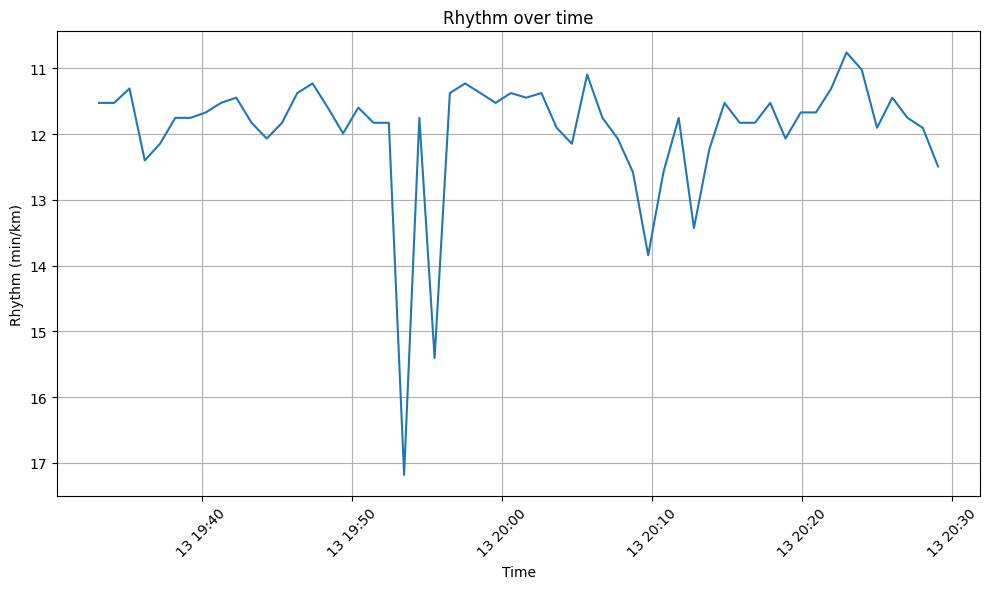

In [72]:
speed_data = data["physical_health"]["events"]["activity_event"][0]["movement"]["speed_granular_data_array"]

# Convert from m/s to min/km
for entry in speed_data:
    speed_m_s = entry["speed_meters_per_second_float"]
    pace_min_per_km = (1000 / speed_m_s) / 60
    entry["pace_min_per_km"] = pace_min_per_km


df = pd.DataFrame(speed_data)
df['datetime'] = pd.to_datetime(df['datetime_string'])

plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['pace_min_per_km'])
plt.xlabel('Time')
plt.ylabel('Rhythm (min/km)')
plt.title('Rhythm over time')
plt.gca().invert_yaxis()  # Invert the Y-axis
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('Cache/rhythm_over_time_spent.png')
plt.show()

### Average Pace

In [73]:
# We will use the variable of "pace_avg_min_per_km_float"

average_pace = data['physical_health']['events']['activity_event'][0]['movement']['pace_avg_min_per_km_float']

if average_pace is None:
    average_pace_result = "Average rhythm values ​​are not available."
    
else:
    average_pace_minutes = int(average_pace)
    average_pace_seconds = int((average_pace - average_pace_minutes) * 60)
    average_pace_result = f"Average Pace: {average_pace_minutes}:{average_pace_seconds:02d}/km"

print(average_pace_result)

Average Pace: 11:56/km


### Moving Time

In [74]:
# We will use the variable of "active_seconds_int"

moving_time = data['physical_health']['events']['activity_event'][0]['activity']['active_seconds_int']

if moving_time is None:
    moving_time_result = "The values ​​of time in motion are not available."
    
else:
    moving_time_minutes = moving_time // 60
    moving_time_seconds = moving_time % 60
    moving_time_result = f"Moving Time: {moving_time_minutes}:{moving_time_seconds:02d}"

print(moving_time_result)

The values ​​of time in motion are not available.


### Event Time

In [75]:
event_time = data['physical_health']['events']['activity_event'][0]['activity']['activity_duration_seconds_int']

if event_time is None:
    event_time_result = "No se tienen los valores del tiempo en movimiento."
    
else:
    event_time_minutes = event_time // 60
    event_time_seconds = event_time % 60
    event_time_result = f"Event time: {event_time_minutes}:{event_time_seconds:02d}"

print(event_time_result)

Event time: 57:04


### Tiempo Transcurrido Promedio

In [76]:
event_time = data['physical_health']['events']['activity_event'][0]['activity']['activity_duration_seconds_int']
distance_traveled = data['physical_health']['events']['activity_event'][0]['distance']['traveled_distance_meters_float']

if event_time is None or distance_traveled is None:
    event_time_average_result = "Average elapsed time values ​​are not available."
    
else:
    distance_traveled_km = round(distance_traveled / 1000, 3)
    event_time_average = event_time // distance_traveled_km
    event_time_average_minutes = int(event_time_average // 60)
    event_time_average_seconds = int(event_time_average % 60)
    event_time_average_result = f"Event time average: {event_time_average_minutes:02d}:{event_time_average_seconds:02d}/km"

print(event_time_average_result)

Event time average: 11:57/km


## Heart Rate

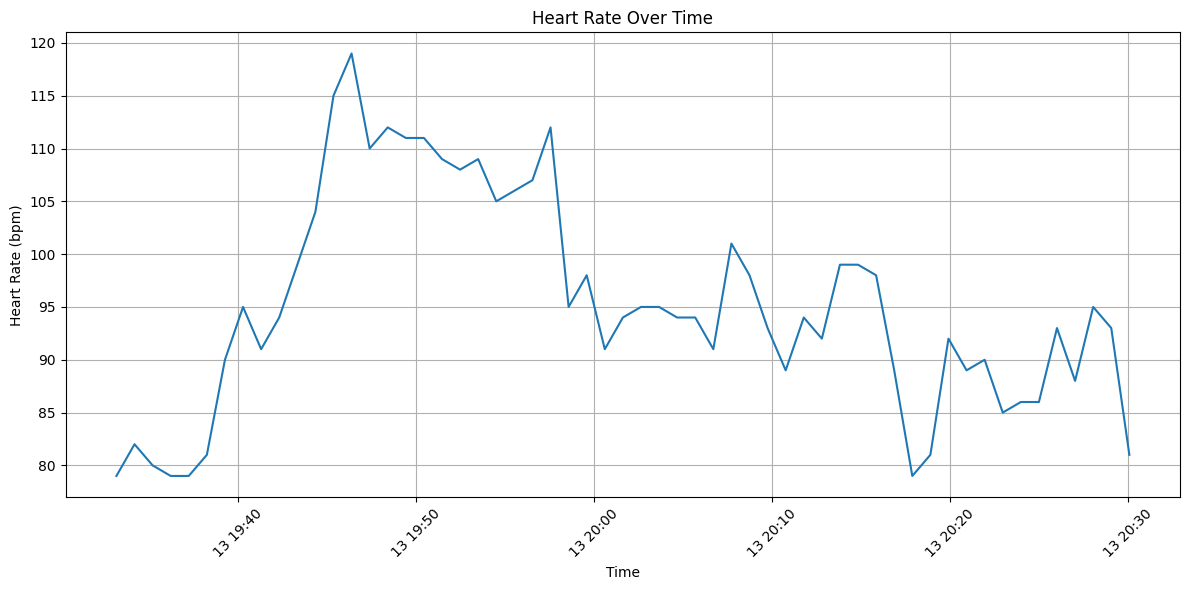

In [77]:
hr_granular_activity_event = data['physical_health']['events']['activity_event'][0]['heart_rate']['hr_granular_data_array']

# Prepare data for plotting
datetimes = [datetime.fromisoformat(item['datetime_string']) for item in hr_granular_activity_event]
heart_rates = [item['hr_bpm_int'] for item in hr_granular_activity_event]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(datetimes, heart_rates, linestyle='-')
plt.title('Heart Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Heart Rate (bpm)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Heart Rate summary

In [78]:
hr_avg_activity_event = data['physical_health']['events']['activity_event'][0]['heart_rate']['hr_avg_bpm_int']
hr_max_activity_event = data['physical_health']['events']['activity_event'][0]['heart_rate']['hr_maximum_bpm_int']
hr_min_activity_event = data['physical_health']['events']['activity_event'][0]['heart_rate']['hr_minimum_bpm_int']

# HR avg
if hr_avg_activity_event is None:
    hr_avg_activity_event_result = "Heart Rate Average: No values ​​were obtained or it is null."
else:
    hr_avg_activity_event_result = f'Heart Rate Average: {hr_avg_activity_event} bpm.'

# HR maximus
if hr_max_activity_event is None:
    hr_max_activity_event_result = "Heart Rate Maximus: No values ​​were obtained or it is null."
else:
    hr_max_activity_event_result = f'Heart Rate Maximus: {hr_max_activity_event} bpm.'
    
# HR minimus
if hr_min_activity_event is None:
    hr_min_activity_event_result = "Heart Rate Minimus: No values ​​were obtained or it is null."
else:
    hr_min_activity_event_result = f'Heart Rate Minimus: {hr_min_activity_event} bpm.'

print(hr_avg_activity_event_result)
print(hr_max_activity_event_result)
print(hr_min_activity_event_result)

Heart Rate Average: 96 bpm.
Heart Rate Maximus: 120 bpm.
Heart Rate Minimus: No values ​​were obtained or it is null.


## Effort Zone

In [79]:
hr_data = data["physical_health"]["events"]["activity_event"][0]['heart_rate']['hr_granular_data_array']
activity_start = datetime.fromisoformat(data["physical_health"]["events"]["activity_event"][0]['activity']['activity_start_datetime_string'])

# Define the HR max and intensity categories
age = 40
hr_max = 220 - age
intensity_levels = [
    ('Very Light', 0 * hr_max, 0.6 * hr_max),
    ('Light', 0.6 * hr_max, 0.7 * hr_max),
    ('Moderate', 0.7 * hr_max, 0.8 * hr_max),
    ('Hard', 0.8 * hr_max, 0.9 * hr_max),
    ('Maximum', 0.9 * hr_max, hr_max)
]

# Initialize the intensity counters
intensity_durations = {level: 0 for level, _, _ in intensity_levels}

# Calculate durations and categorize
previous_datetime = activity_start
for entry in hr_data:
    current_datetime = datetime.fromisoformat(entry['datetime_string'])
    hr_bpm = entry['hr_bpm_int']
    
    # Calculate the time difference from the previous entry
    duration = (current_datetime - previous_datetime).total_seconds()
    
    # Categorize the HR bpm
    for level, lower_bound, upper_bound in intensity_levels:
        if lower_bound <= hr_bpm < upper_bound:
            intensity_durations[level] += duration
            break
    
    previous_datetime = current_datetime

# Calculate total duration
total_duration = sum(intensity_durations.values())

# Calculate the percentage of time spent in each intensity level
intensity_percentages_rounded = {level: round((duration / total_duration) * 100, 2) for level, duration in intensity_durations.items()}

# Create the final result with the total time in each level and the percentages
intensity_durations_hms = {level: str(timedelta(seconds=int(duration))) for level, duration in intensity_durations.items()}


# Create a DataFrame to present the results
df_result = pd.DataFrame({
    'Intensity Level': intensity_durations.keys(),
    'Total Time (HH:MM:SS)': intensity_durations_hms.values(),
    'Percentage (%)': intensity_percentages_rounded.values()
})

# Show the DataFrame
print(df_result)

  Intensity Level Total Time (HH:MM:SS)  Percentage (%)
0      Very Light               0:46:46           82.14
1           Light               0:10:10           17.86
2        Moderate               0:00:00            0.00
3            Hard               0:00:00            0.00
4         Maximum               0:00:00            0.00


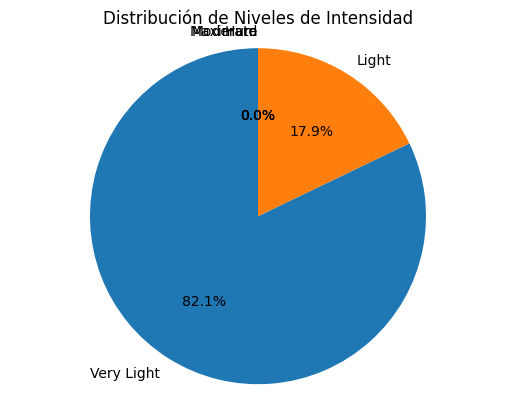

In [80]:
# Crear un gráfico de pie
fig, ax = plt.subplots()
ax.pie(intensity_percentages_rounded.values(), labels=intensity_percentages_rounded.keys(), autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Para que el gráfico sea un círculo

# Título del gráfico
plt.title('Distribución de Niveles de Intensidad')

# Mostrar el gráfico
plt.show()